# Diving Deeper: Improving Generalization and Out-of-Sample Detection for Deep-Sea Species Identification

### Import libraries

In [2]:
import ast
from collections import Counter
from fastai.vision.all import *
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import gc

In [1]:
import torch
print(torch.cuda.is_available())

True


## Set Up and Preprocessing of the Dataset

In [1]:
# Path to the training images folder
path = 'images/'

In [4]:
# Identify the corrupted images in the folder

corrupted_images = []

# iterate over every file in the directory
for filename in os.listdir(path):
    # get the file path
    filepath = os.path.join(path, filename)
    
    # try to open the file with PIL
    try:
        with Image.open(filepath) as img:
            img.verify()
    except (IOError, SyntaxError) as e:
        # if an exception is raised, the file is corrupted
        corrupted_images.append(filename)

print(corrupted_images)

['b0dbe789-d872-41ef-8714-b89ee5c6a607.png', '59d1f516-e39f-4fe3-9eae-78335826980e.png']


In [5]:
# Identify corrupted images in the folder using a slighly more complex method,
# the same two images are identified, however.

corrupted_images_full = []

# iterate over every file in the directory
for filename in os.listdir(path):
    # get the file path
    filepath = os.path.join(path, filename)
    
    # try to open the file with PIL
    try:
        img = Image.open(filepath)  
        img.verify()
        img.close()
        img = Image.open(filepath)  
        pixels = img.load() 
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        img.close()
        
    except (IOError, SyntaxError) as e:
        # if an exception is raised, the file is corrupted
        corrupted_images_full.append(filename)

print(corrupted_images_full)

['b0dbe789-d872-41ef-8714-b89ee5c6a607.png', '59d1f516-e39f-4fe3-9eae-78335826980e.png']


### Dataframe Creation

In [27]:
# Create dataframe from the provided file

df = pd.read_csv('multilabel_classification/train.csv')
df

id                categories
0     3b6f01ae-5bde-434d-9b06-79b269421ed6                     [1.0]
1     dce21f7c-20e5-482b-bd90-c038f8464c03                     [1.0]
2     4a7f2199-772d-486d-b8e2-b651246316b5                     [1.0]
3     3bddedf6-4ff8-4e81-876a-564d2b03b364    [1.0, 9.0, 11.0, 88.0]
4     3f735021-f5de-4168-b139-74bf2859d12a  [1.0, 37.0, 51.0, 119.0]
...                                    ...                       ...
5945  701715fe-b278-4310-ac1d-cca8ddacc830                   [283.0]
5946  45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a                   [283.0]
5947  676b982a-deeb-46ee-b47d-8a97a1b0c76c                   [283.0]
5948  7e09c9a9-72e5-4374-9ed6-dae1ee2ea33d                   [286.0]
5949  06acea78-c8b5-48fe-8678-cb24458ebc6a                   [286.0]

[5950 rows x 2 columns]

In [28]:
df.loc[3, 'categories']

'[1.0, 9.0, 11.0, 88.0]'

In [29]:
# Convert string 'categories' column 
df['categories'] = df['categories'].apply(ast.literal_eval)
df.head()

id                categories
0  3b6f01ae-5bde-434d-9b06-79b269421ed6                     [1.0]
1  dce21f7c-20e5-482b-bd90-c038f8464c03                     [1.0]
2  4a7f2199-772d-486d-b8e2-b651246316b5                     [1.0]
3  3bddedf6-4ff8-4e81-876a-564d2b03b364    [1.0, 9.0, 11.0, 88.0]
4  3f735021-f5de-4168-b139-74bf2859d12a  [1.0, 37.0, 51.0, 119.0]

In [10]:
len(df)

5950

In [11]:
# remove the corrupted images from the dataframe
for image in corrupted_images_full:
    name = image[:-4]
    df.drop(df[df['id'] == name].index, inplace=True)

In [12]:
len(df)

5948

In [25]:
# Load the supercategories
category_key = pd.read_csv('category_key.csv')
category_key

id           name supercat
0      1     Actiniaria  Anemone
1      2     Actinernus  Anemone
2      3     Actiniidae  Anemone
3      4  Actinoscyphia  Anemone
4      5       Bolocera  Anemone
..   ...            ...      ...
285  286     Polychaeta     Worm
286  287     Polynoidae     Worm
287  288     Sabellidae     Worm
288  289     Serpulidae     Worm
289  290   Terebellidae     Worm

[290 rows x 3 columns]

In [24]:
# Sample Submission
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

id          categories  osd
0  8119e2ac-ca3a-4c3b-9e1c-c7a079a705c8  1 146 10 12 44 210  0.1
1   11e2891-93a3-4532-a4ea-6e22e335ae54           17 82 251  0.9

## Data Exploration

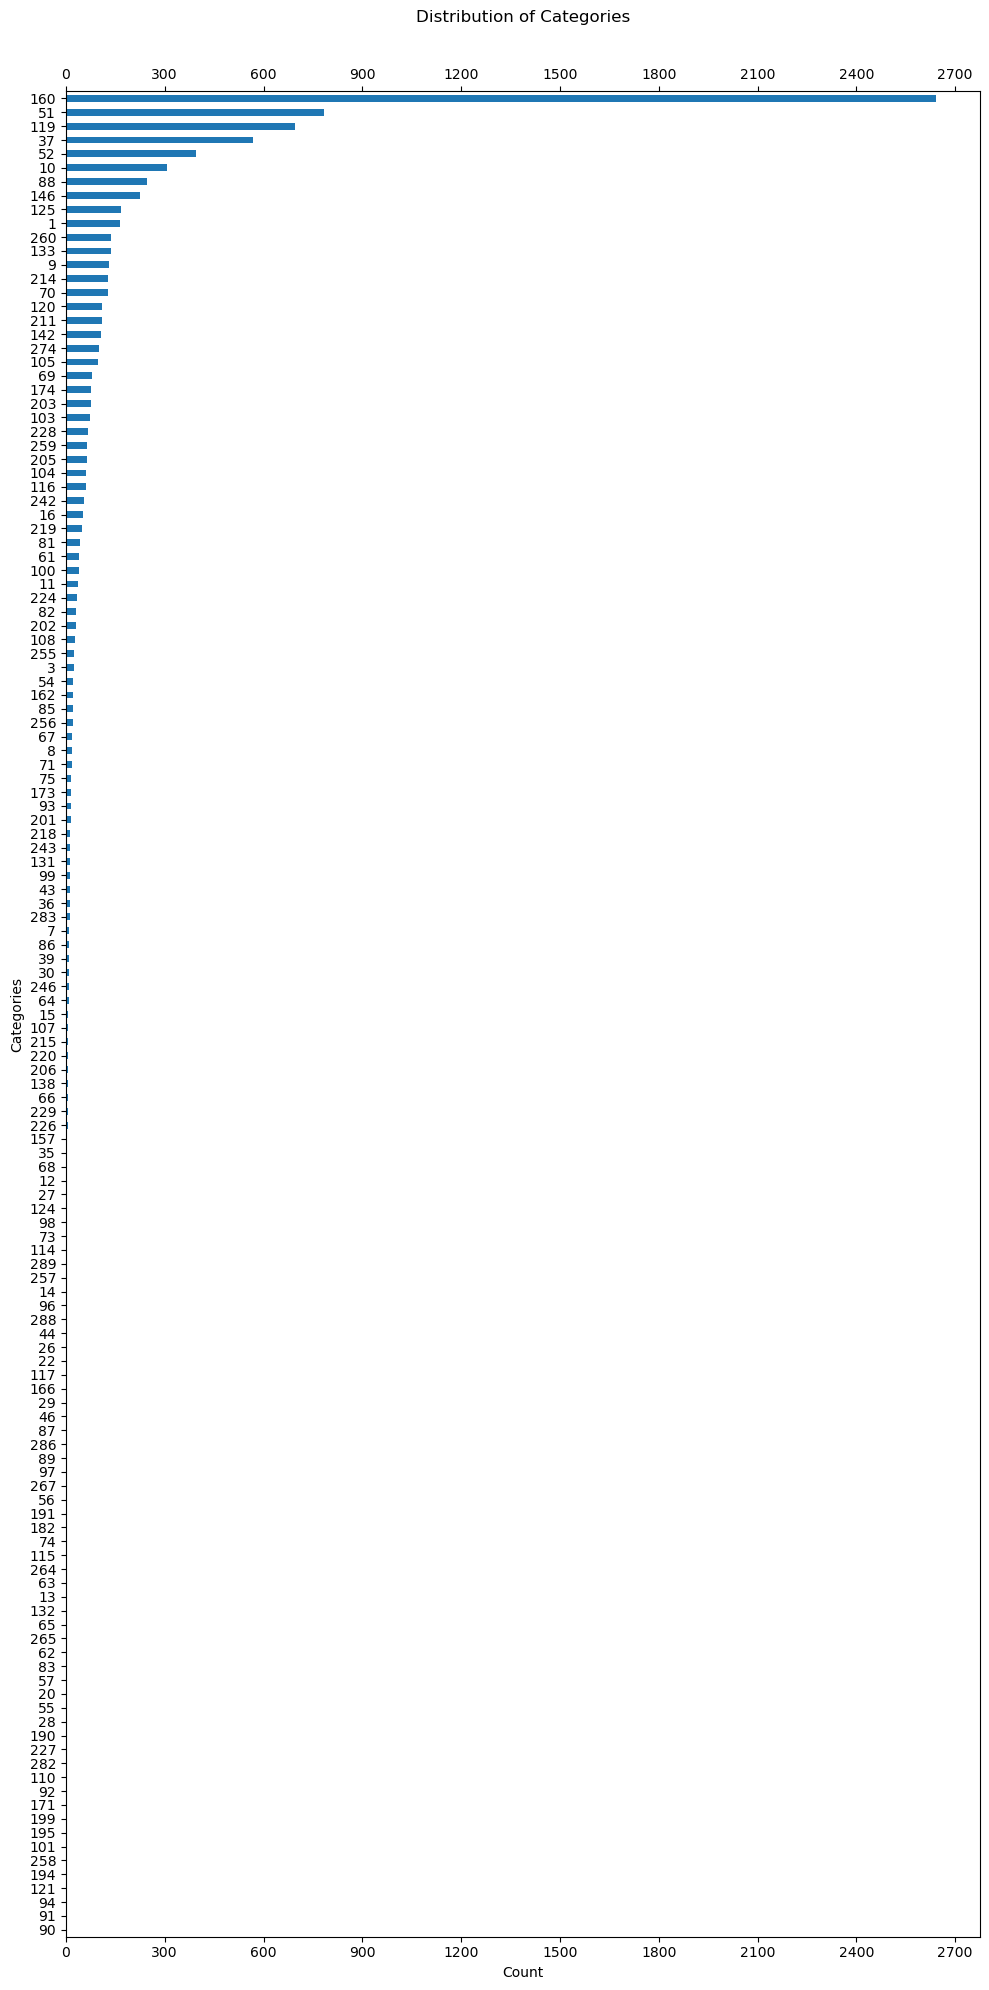

In [35]:
from matplotlib.ticker import MaxNLocator

# Explode the 'categories' column
df_exploded = df['categories'].explode()

# Count the occurrences of each category
category_counts = df_exploded.value_counts()
category_counts_sorted = category_counts.sort_values(ascending=False)

# Plot the histogram 
plt.figure(figsize=(10, 20))
ax = category_counts_sorted.plot(kind='barh')
ax.invert_yaxis()
plt.tick_params(axis='x', top=True, labeltop=True)
plt.title('Distribution of Categories', pad=50)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Modify the y-axis labels to drop the last '.0'
ax.set_yticklabels([int(x) for x in category_counts_sorted.index])

# Display the plot
plt.xlabel('Count')
plt.ylabel('Categories')
plt.tight_layout()
plt.show()


In [61]:
print((df_exploded.value_counts() < 10).sum())

73


In [41]:
super_df = df.copy()

if isinstance(super_df['categories'][0], str):
    super_df['categories'] = super_df['categories'].apply(ast.literal_eval)

# Create a category to supercat dictionary
category_to_supercat = category_key.set_index('id')['supercat'].to_dict()

# Function to replace categories with supercats
def replace_with_supercat(category_list):
    return [category_to_supercat.get(cat, cat) for cat in category_list]

# Apply the function on the 'categories' column
super_df['categories'] = super_df['categories'].apply(replace_with_supercat)

In [42]:
super_df.head()

id                          categories
0  3b6f01ae-5bde-434d-9b06-79b269421ed6                           [Anemone]
1  dce21f7c-20e5-482b-bd90-c038f8464c03                           [Anemone]
2  4a7f2199-772d-486d-b8e2-b651246316b5                           [Anemone]
3  3bddedf6-4ff8-4e81-876a-564d2b03b364  [Anemone, Anemone, Fish, Sea star]
4  3f735021-f5de-4168-b139-74bf2859d12a     [Anemone, Fish, Fish, Sea star]

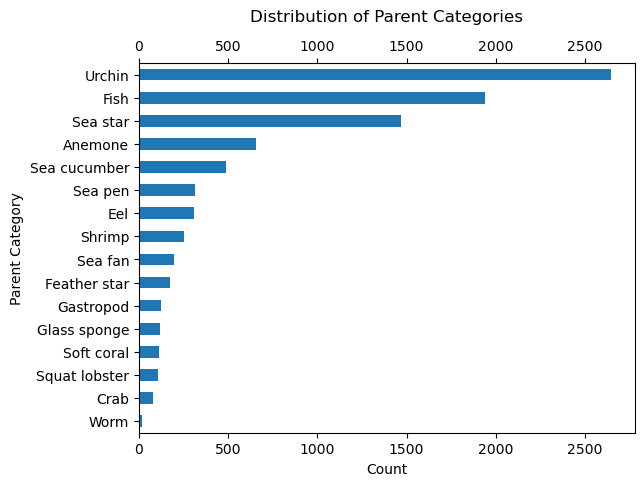

In [52]:
# Explode the 'categories' column
super_df_exploded = super_df['categories'].explode()

# Count the occurrence of each category
category_counts = super_df_exploded.value_counts()

# Reverse the order of category counts
category_counts = category_counts.iloc[::-1]

# Inverted horizontal bars
category_counts.plot(kind='barh')

# Plot
plt.xlabel('Count')
plt.ylabel('Parent Category')
plt.tick_params(axis='x', top=True, labeltop=True)
plt.title('Distribution of Parent Categories', pad=30)

plt.show()


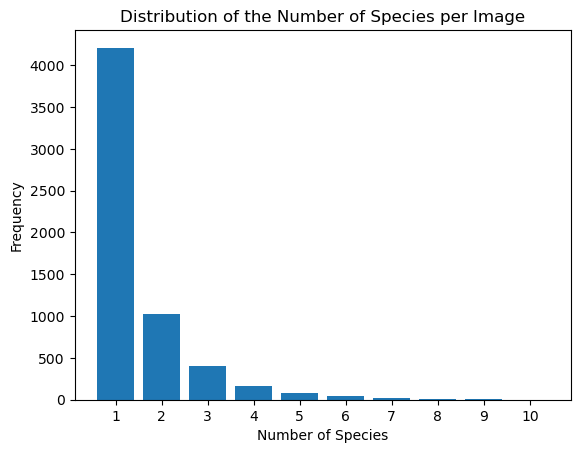

In [71]:
# Count the number of categories per image
category_counts = df['categories'].apply(lambda x: len(x))

# Calculate the unique counts and their frequencies
unique_counts, count_freqs = np.unique(category_counts, return_counts=True)

# Plot
plt.bar(unique_counts, count_freqs, width=0.8)
plt.xlabel('Number of Species')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Species per Image')

# Set the x-axis tick labels
plt.xticks(unique_counts)

plt.show()


In [72]:
category_count = pd.DataFrame(category_key['supercat'].value_counts()).reset_index()
category_count.columns = ['supercat', 'count']
category_count['%'] = np.round(category_count['count'] / len(category_key), 4) * 100
category_count.set_index('supercat', inplace=True)

category_count

count      %
supercat                   
Fish              46  15.86
Sea star          36  12.41
Glass sponge      23   7.93
Sea cucumber      22   7.59
Sea fan           22   7.59
Eel               17   5.86
Sea pen           16   5.52
Crab              15   5.17
Gastropod         14   4.83
Worm              12   4.14
Squat lobster     12   4.14
Anemone           10   3.45
Urchin            10   3.45
Shrimp             8   2.76
Black coral        7   2.41
Soft coral         7   2.41
Feather star       6   2.07
Stony coral        3   1.03
Barnacle           3   1.03
Sea spider         1   0.34

## Multi-label Classification - Parent Categories

In [73]:
# Create a counter for each category
counter = Counter()
super_df['categories'].apply(lambda x: counter.update(x))

# Set the threshold
X = 100

# Get categories that appear more than X times
valid_categories = {k for k, count in counter.items() if count >= X}

# Function to filter categories
def filter_categories(category_list):
    return [cat for cat in category_list if cat in valid_categories]

# Apply the function on the 'categories' column
super_df['categories'] = super_df['categories'].apply(filter_categories)

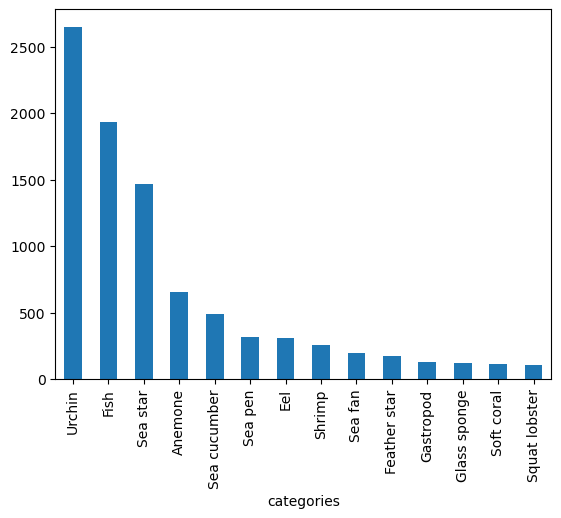

In [74]:
# Explode the 'categories' column
super_df_exploded = super_df['categories'].explode()

# Count the occurrence of each category and plot the histogram
super_df_exploded.value_counts().plot(kind='bar')

plt.show()

In [75]:
def get_x(r): return os.path.join(path, r['id'] + '.png')
def get_y(r): return list(map(str, r['categories']))

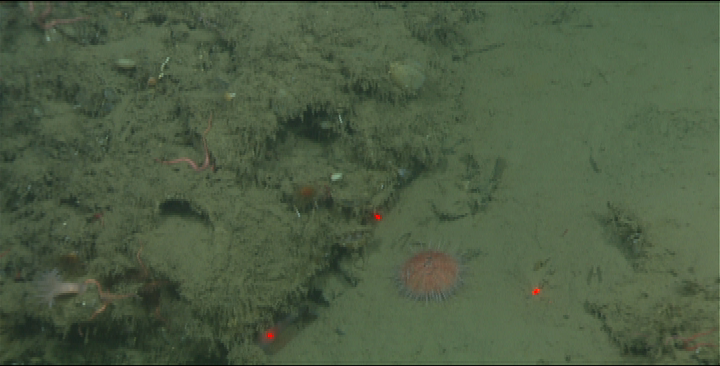

In [78]:
img = PILImage.create(get_x(super_df.iloc[10])); img

In [79]:
# DataBlock definition
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(seed=42), 
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(460),  
                   batch_tfms=aug_transforms(mult=2, do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=224)) 

In [80]:
# Load data from the DataFrame
dls = dblock.dataloaders(super_df, bs=64)

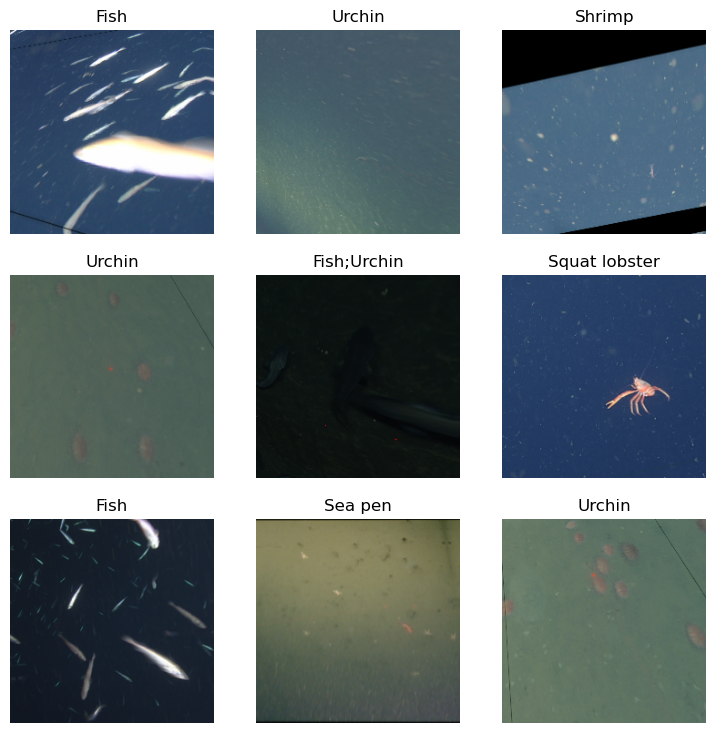

In [81]:
dls.show_batch()

In [82]:
# Learner definition
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.1))

/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


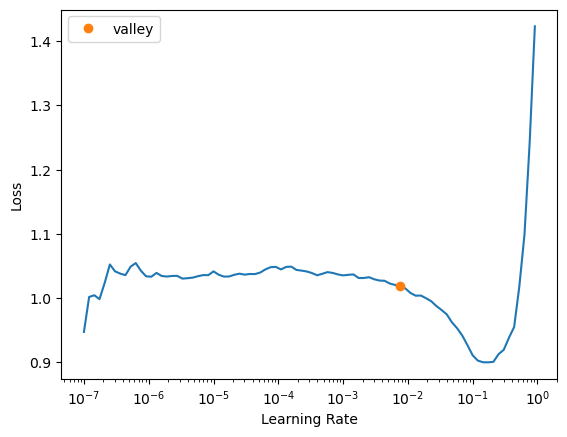

In [ ]:
# Learning rate optimization
lr_min = learn.lr_find()

In [ ]:
print(lr_min)

SuggestedLRs(valley=0.007585775572806597)


In [ ]:
# Model training
lr_min= 0.007
learn.fine_tune(10, base_lr=lr_min)

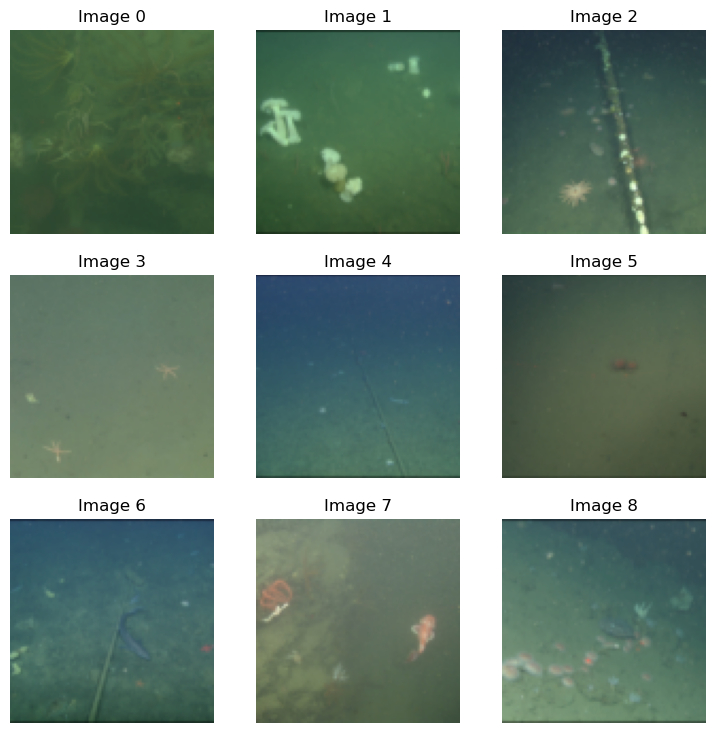

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [ ]:
learn.export('supercat_model.pkl')

In [ ]:
learn.load('supercat_model.pkl')

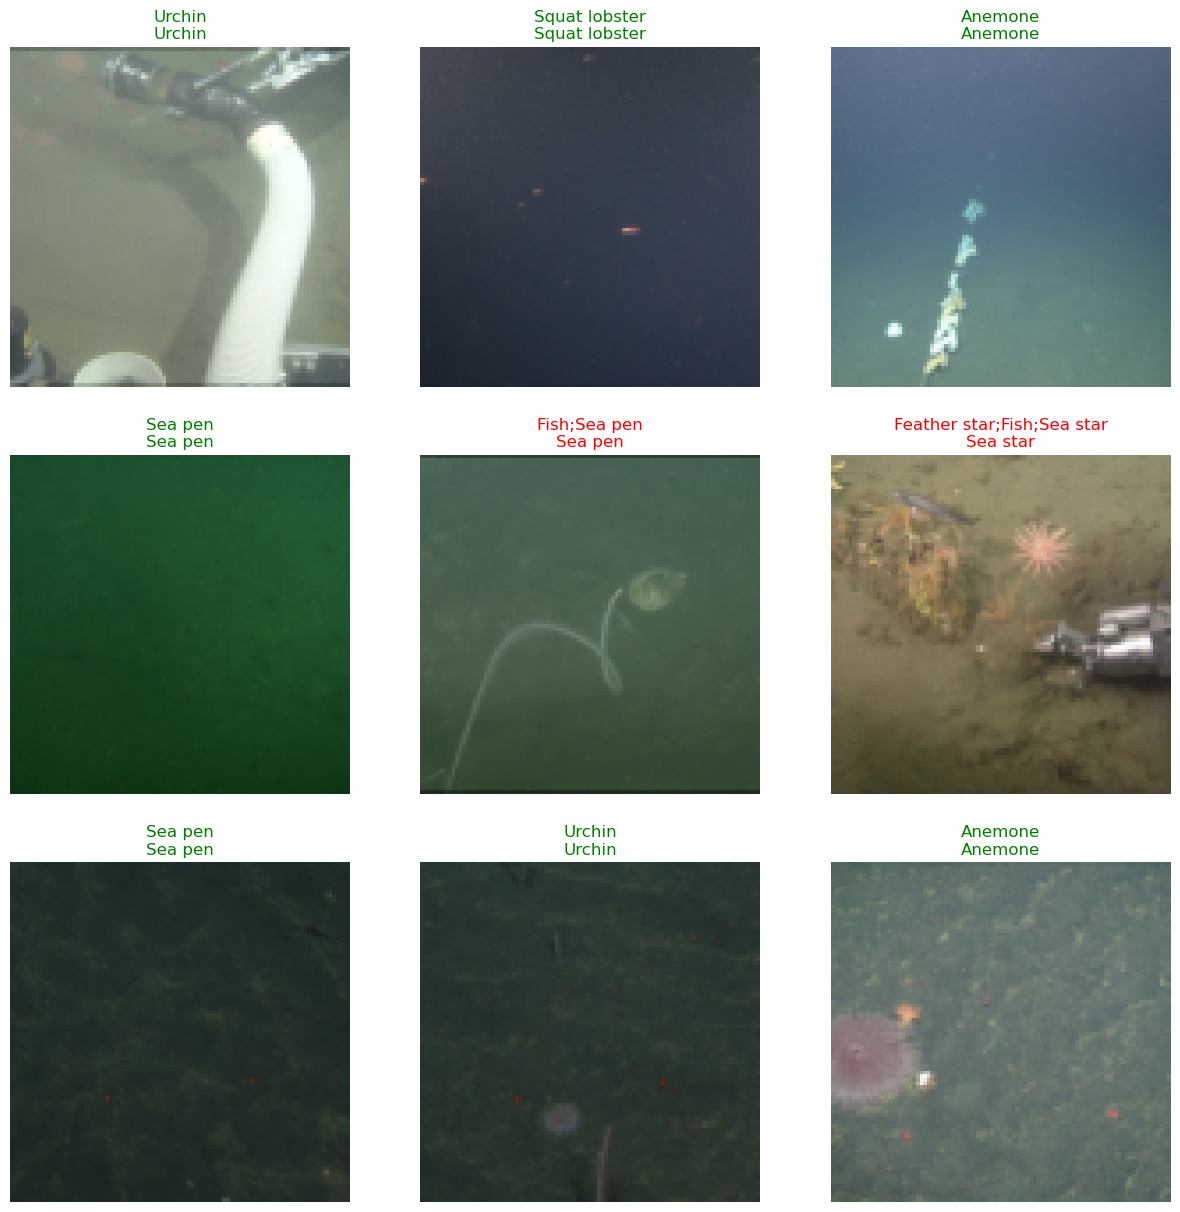

In [ ]:
learn.show_results(figsize=(15,15))

## Multi-label Classification - Cropped Fine-Grained Categories

In [ ]:
cropped_df = df.copy()
cropped_df.shape

(5948, 2)

In [ ]:
# Create a counter for each category
counter = Counter()
cropped_df['categories'].apply(lambda x: counter.update(x))

# Set the threshold
X = 50

# Get categories that appear more than X times
valid_categories = {k for k, count in counter.items() if count >= X}

# Function to filter categories
def filter_categories(category_list):
    return [cat for cat in category_list if cat in valid_categories]

# Apply the function on the 'categories' column
cropped_df['categories'] = cropped_df['categories'].apply(filter_categories)

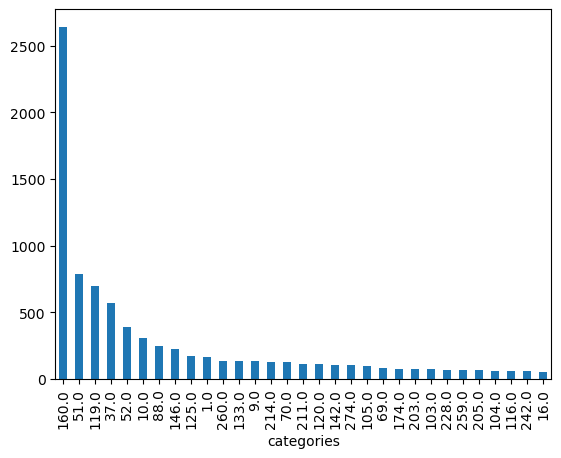

In [ ]:
# Explode the 'categories' column
cropped_df_exploded = cropped_df['categories'].explode()

# Histogram of the cropped categories
cropped_df_exploded.value_counts().plot(kind='bar')

plt.show()

In [ ]:
# DataBlock definition
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(seed=42),  
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=460)) 

In [ ]:
# Load data from the DataFrame
dls = dblock.dataloaders(cropped_df, bs=10, num_workers=0)

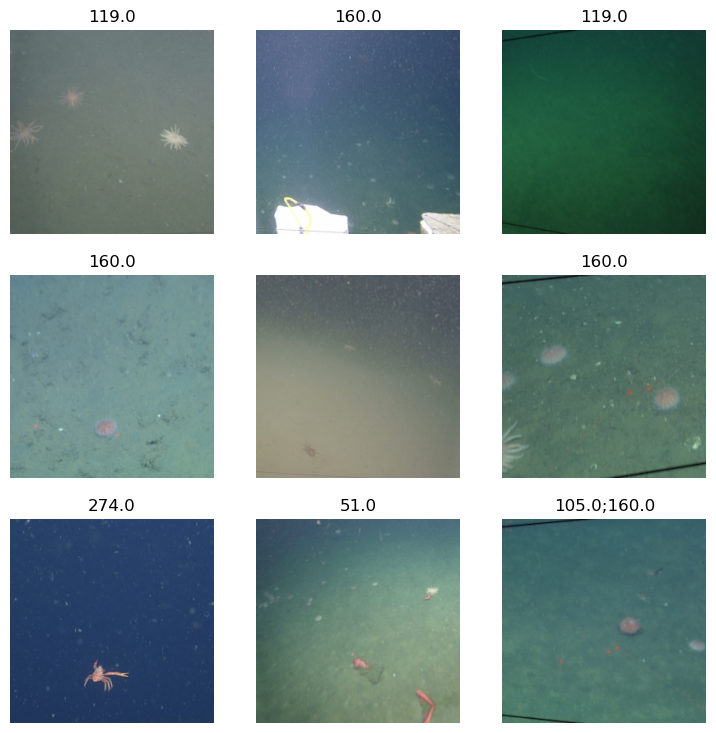

In [ ]:
dls.show_batch()

In [ ]:
# Learner definition
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


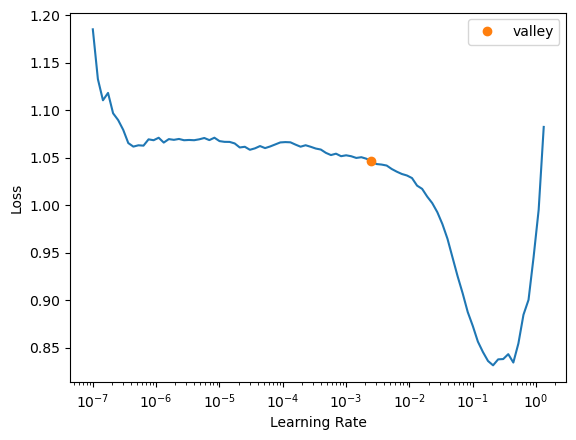

In [ ]:
# Learning rate optimization
lr_min = learn.lr_find()

In [ ]:
print(lr_min)

SuggestedLRs(valley=0.002511886414140463)


In [ ]:
# Model Training
lr_min = 0.0025
learn.fine_tune(5, base_lr=lr_min) 

In [ ]:
learn.export('cropped_model.pkl')

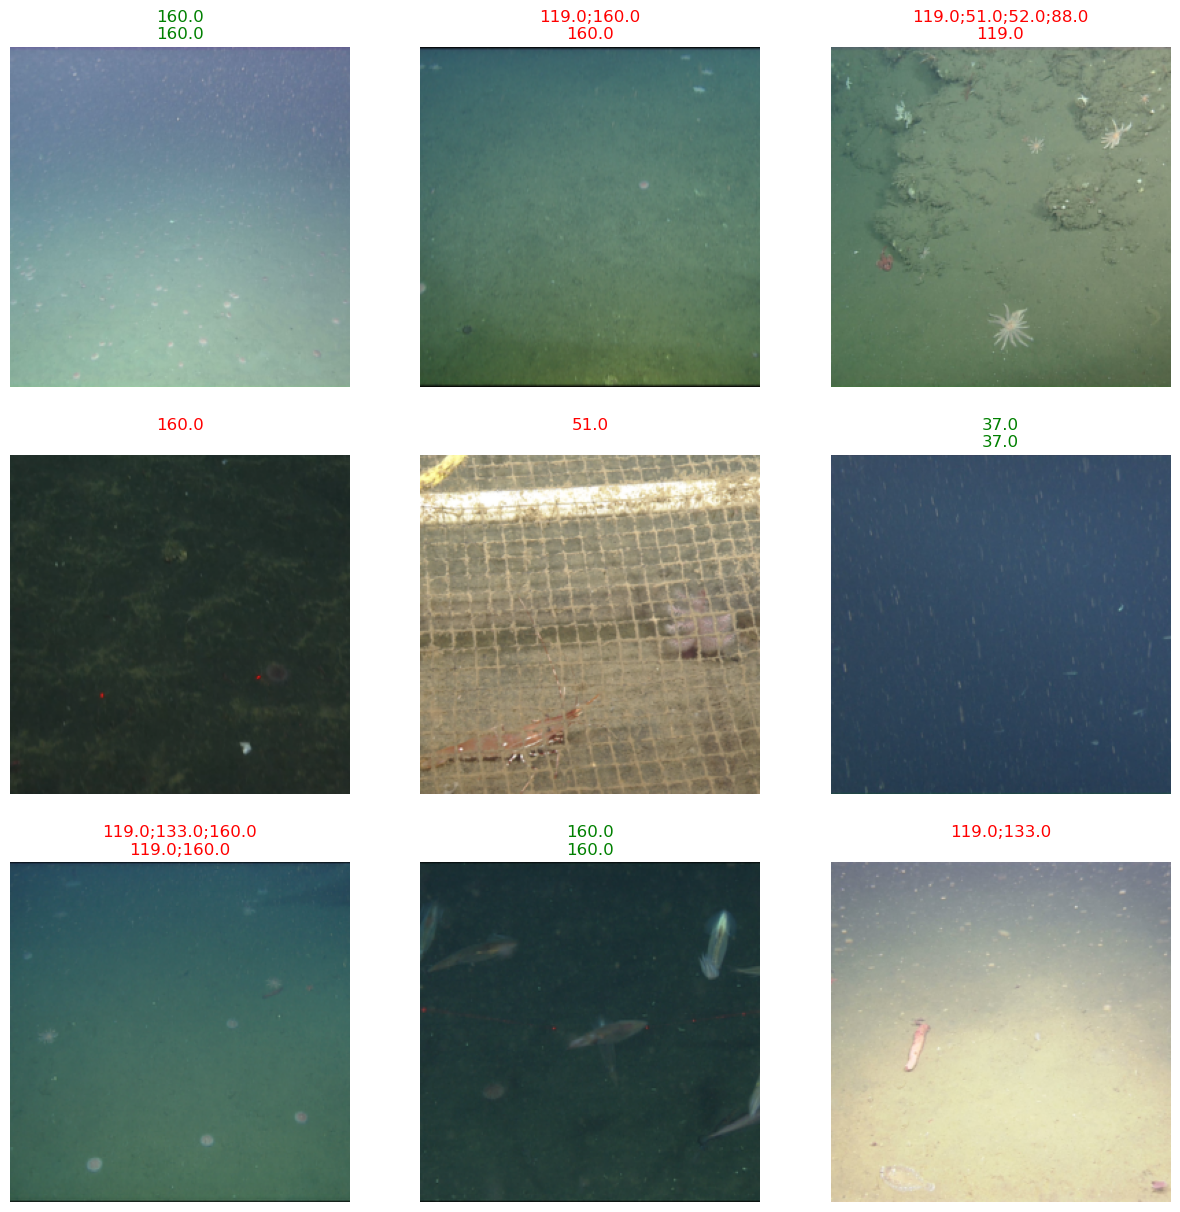

In [ ]:
learn.show_results(figsize=(15,15))

## Multi-label Classification - All Fine-Grained Categories

In [ ]:
def oversample(df):
    # Flattening the categories into one single list
    all_labels = [label for sublist in df.categories.tolist() for label in sublist]

    # Counting the occurrences
    label_counts = Counter(all_labels)

    # Set the number of occurrence
    num_instances = 20

    new_rows = []

    # Oversampling
    for i, row in df.iterrows():
        labels = row['categories']
        for label in labels:
            if label_counts[label] < num_instances:
                diff = num_instances - label_counts[label]
                for _ in range(diff):
                    new_rows.append(row)

    # Concatenating the original and oversampled dataframes
    df = pd.concat([df, pd.DataFrame(new_rows, columns=df.columns)])

    return df


oversampled_df = oversample(df)

In [ ]:
oversampled_df

id                categories
0     3b6f01ae-5bde-434d-9b06-79b269421ed6                     [1.0]
1     dce21f7c-20e5-482b-bd90-c038f8464c03                     [1.0]
2     4a7f2199-772d-486d-b8e2-b651246316b5                     [1.0]
3     3bddedf6-4ff8-4e81-876a-564d2b03b364    [1.0, 9.0, 11.0, 88.0]
4     3f735021-f5de-4168-b139-74bf2859d12a  [1.0, 37.0, 51.0, 119.0]
...                                    ...                       ...
5949  06acea78-c8b5-48fe-8678-cb24458ebc6a                   [286.0]
5949  06acea78-c8b5-48fe-8678-cb24458ebc6a                   [286.0]
5949  06acea78-c8b5-48fe-8678-cb24458ebc6a                   [286.0]
5949  06acea78-c8b5-48fe-8678-cb24458ebc6a                   [286.0]
5949  06acea78-c8b5-48fe-8678-cb24458ebc6a                   [286.0]

[10216 rows x 2 columns]

In [ ]:
def get_x(r): return os.path.join(path, r['id'] + '.png')
def get_y(r): return list(map(str, r['categories']))

In [ ]:
get_x(oversampled_df.iloc[0])

'images/3b6f01ae-5bde-434d-9b06-79b269421ed6.png'

In [ ]:
get_y(oversampled_df.iloc[3])

['1.0', '9.0', '11.0', '88.0']

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.4, seed=42),  
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(460),  
                   batch_tfms=aug_transforms(mult=2, do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=224))


In [ ]:
# Load data from the DataFrame
dls = dblock.dataloaders(oversampled_df, bs=64)

In [ ]:
torch.save(dls, 'dls.pkl')

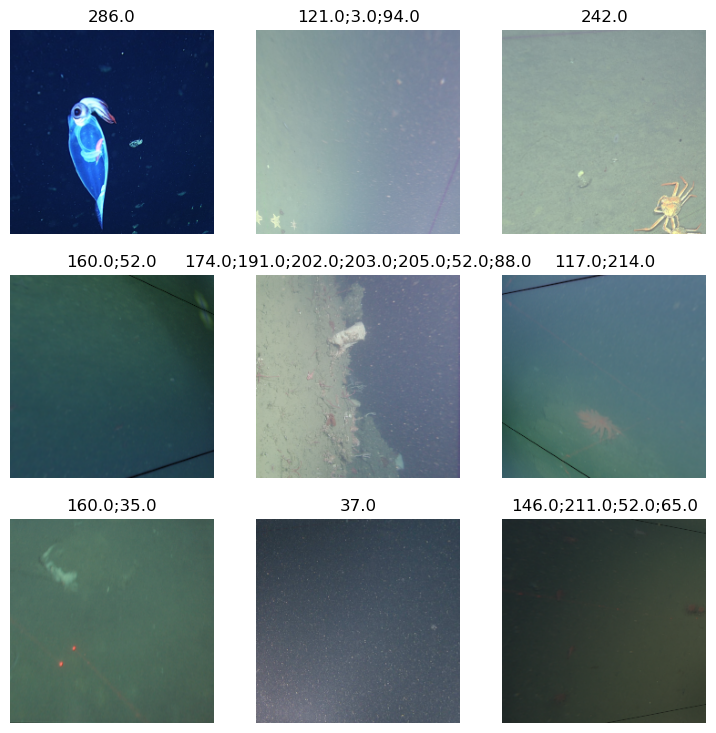

In [ ]:
dls.show_batch()

In [ ]:
# Learner definition
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2))

/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/praxis/mambaforge/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


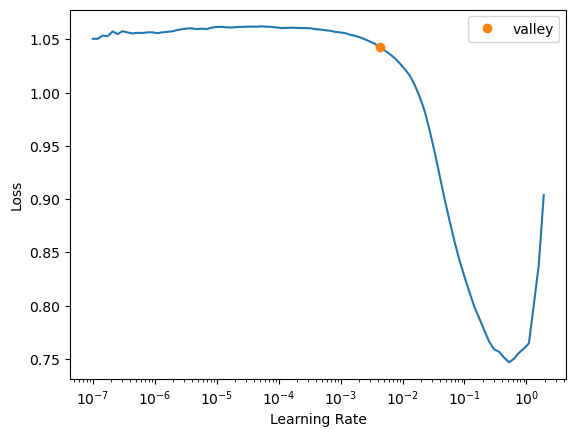

In [ ]:
# Learning rate optimization
lr_min = learn.lr_find()

In [ ]:
print(lr_min)

SuggestedLRs(valley=0.004365158267319202)


In [ ]:
lr_min= 0.004

In [ ]:
def get_unique_labels(dls):
    train_labels = []
    valid_labels = []
    
    # Unique labels in training set
    for _, y in dls.train:
        for label in y.cpu(): 
            train_labels.extend([dls.vocab[i] for i in np.where(label == 1)[0]])
    train_labels = set(train_labels)
    
    # Unique labels in validation set
    for _, y in dls.valid:
        for label in y.cpu(): 
            valid_labels.extend([dls.vocab[i] for i in np.where(label == 1)[0]])
    valid_labels = set(valid_labels)
    
    return train_labels, valid_labels

train_labels, valid_labels = get_unique_labels(dls)

# Check that all labels are present in both the validation and training sets
missing_in_train = valid_labels - train_labels
missing_in_valid = train_labels - valid_labels

print('Labels present in validation set but missing in training set:', missing_in_train)
print('Labels present in training set but missing in validation set:', missing_in_valid)



Labels present in validation set but missing in training set: set()
Labels present in training set but missing in validation set: set()


In [ ]:
# Model training
learn.fine_tune(3, base_lr=lr_min, freeze_epochs=2)

In [ ]:
learn.export('oversampled_model.pkl')

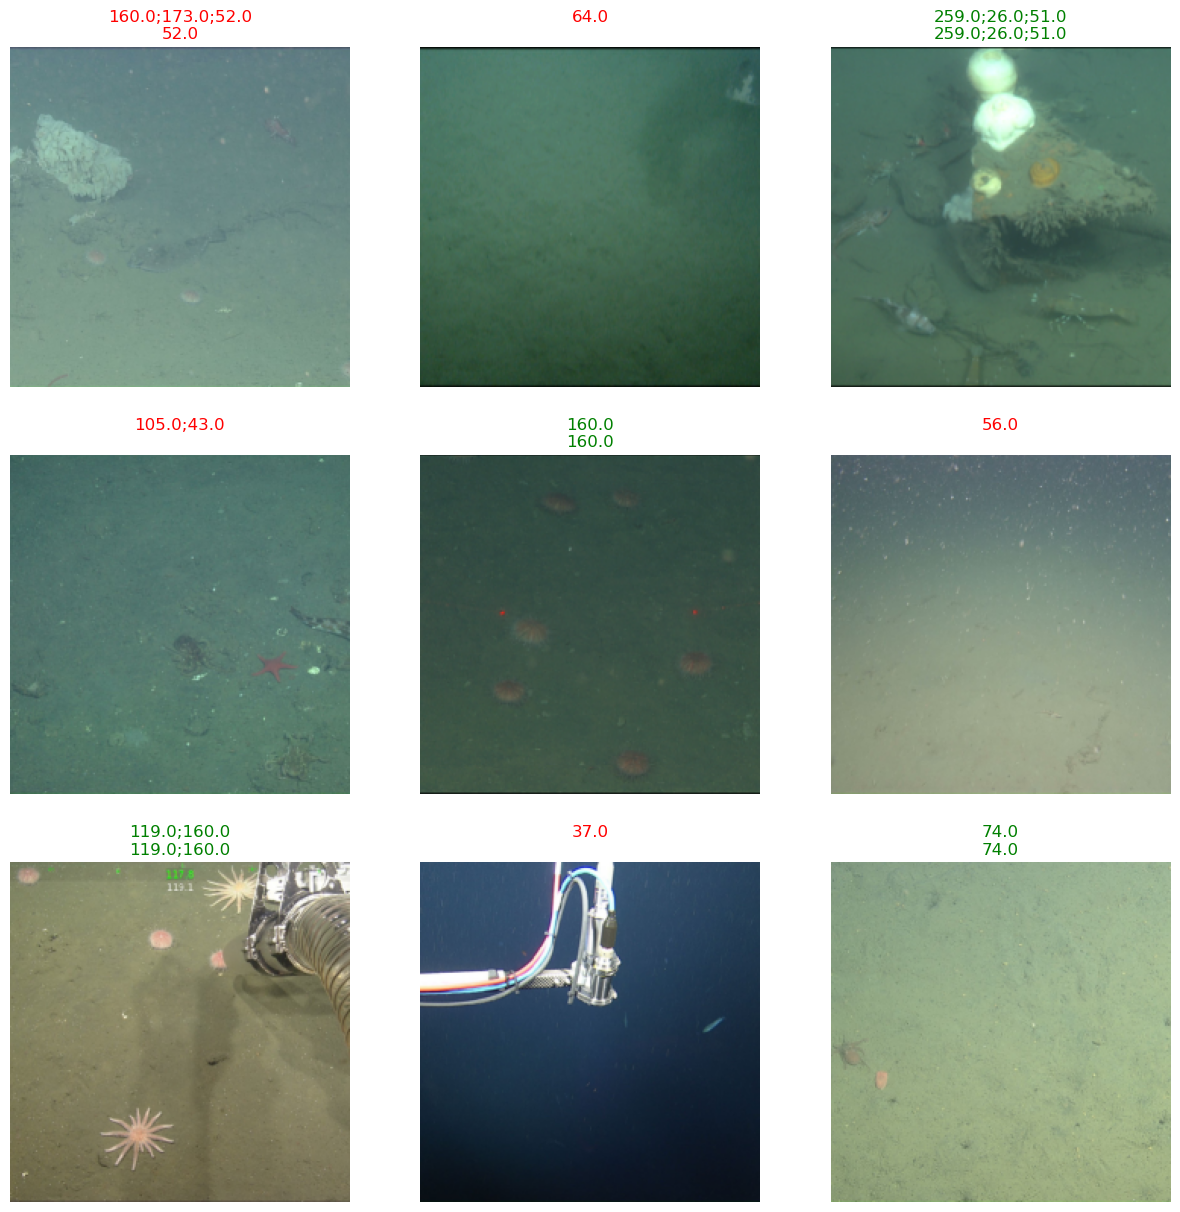

In [ ]:
learn.show_results(figsize=(15,15))

In [ ]:
loss, accuracy = learn.validate()
print(f"Loss: {loss}, Accuracy: {accuracy}")

Loss: 0.030615998432040215, Accuracy: 0.9888120293617249


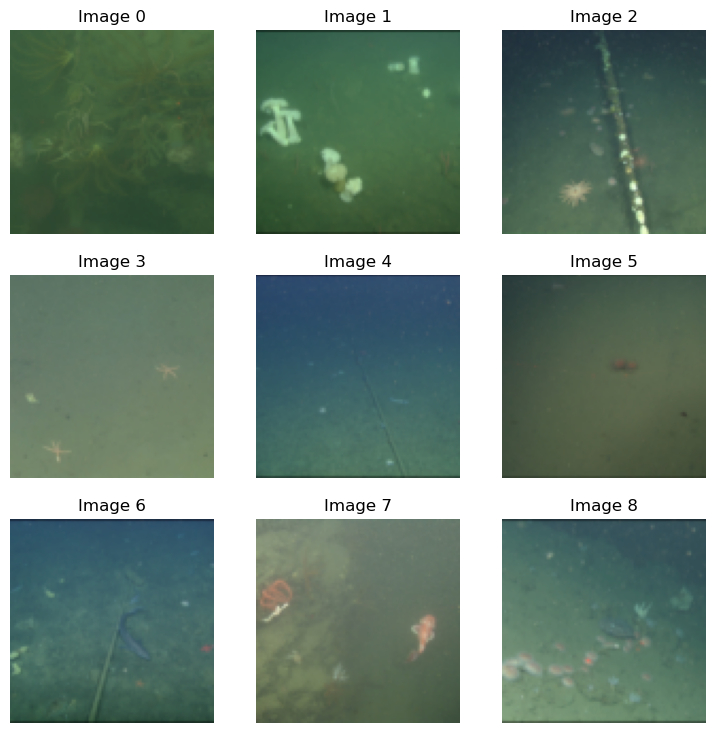

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

## Multi-label Classification - Evaluation

In [ ]:
def get_x(r): return os.path.join(path, r['id'] + '.png')
def get_y(r): return list(map(str, r['categories']))

# Path to the folder with images for predictions
path = 'all_images/images/'

# Load the trained model
learn = load_learner('oversampled_model.pkl')


In [ ]:
try:
    # Try to read the intermediate results
    df = pd.read_csv('predictions.csv')
except FileNotFoundError:
    # Otherwise, start from scratch
    df = pd.read_csv('eval_osd_scores.csv.xls')
    df.insert(loc=1, column='categories', value='')


batch_size = 100

# Predict the categories for each image
for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size]
    
    for j, row in batch.iterrows():
        # Skip if already processed
        if pd.notna(df.loc[j, 'categories']) and df.loc[j, 'categories'] != '':
            continue
        
        try:
            image_file = row['id'] + '.png'
            img = PILImage.create(os.path.join(path, image_file))
            pred, pred_idx, probs = learn.predict(img)

            # Store the predicted categories
            df.at[j, 'categories'] = [category for category in pred]

            # Delete unused variables
            del img, pred, pred_idx, probs

        except Exception as e:
            print(f"Error with file {image_file}: {e}")

    # Clear memory
    gc.collect()

    # Save the dataframe periodically
    df.to_csv('predictions.csv', index=False)

# Final save
df.to_csv('predictions.csv', index=False)

# Delete unused variables
del df, learn
gc.collect()

In [ ]:
try:
    # Try to read the intermediate results
    df = pd.read_csv('predictions.csv')
except FileNotFoundError:
    # Otherwise, start from scratch
    df = pd.read_csv('eval_osd_scores.csv.xls')
    df.insert(loc=1, column='categories', value='')

batch_size = 100

# Predict the categories for each image
for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size]
    
    for j, row in batch.iterrows():
        # Skip if already processed
        if pd.notna(df.loc[j, 'categories']) and df.loc[j, 'categories'] != '[]':
            continue
        
        preds, pred_class = None, None
        
        try:
            image_file = row['id'] + '.png'
            img_path = os.path.join(path, image_file)
            
            # DataLoader for inference
            dl = learn.dls.test_dl([img_path], rm_type_tfms=None, num_workers=0)
            
            # Check if predictions are empty
            if df.loc[j, 'categories'] == '[]':
                # Probabilities for all classes
                preds, _ = learn.get_preds(dl=dl)
                # Class with highest prob
                pred_class = learn.dls.vocab[preds[0].argmax()]
                # Store the predicted category
                df.at[j, 'categories'] = pred_class
            
            # Delete unused variables
            del dl

        except Exception as e:
            print(f"Error with file {image_file}: {e}")
            
        if preds is not None: del preds
        if pred_class is not None: del pred_class

    # Clear memory
    gc.collect()

    # Save the dataframe periodically
    df.to_csv('predictions_full.csv', index=False)

# Final save
df.to_csv('predictions_full.csv', index=False)

# Delete unused variables
del df, learn
gc.collect()


2858

### Final Submission Preparation

In [ ]:
df = pd.read_csv('predictions.csv')

In [ ]:
df

id categories       osd
0      4172b65a-8b4f-4175-94e4-00187e2d5f33      174.0  0.265826
1      9d263fd4-f786-42bf-8e0c-2d5be7c81b49  ['119.0']  0.184472
2      c114ccb9-cf89-4d98-807b-f8636477c6ca       70.0  0.307529
3      95ba3acc-859b-4a99-8c30-b38a91a1be28      119.0  0.173011
4      0c4bdb90-c715-4c01-81d1-aa7f49534ac7  ['160.0']  0.236649
...                                     ...        ...       ...
10739  8c6fbb81-eaeb-488e-9ca8-95d92a70505d       69.0  0.200009
10740  f5d39dea-afb2-4ca7-b3a7-5ea35e038b98      160.0  0.194303
10741  5833854d-3d75-4a25-b419-5e332d5ba931  ['160.0']  0.153544
10742  d6b50e1b-e12d-410e-ac65-437115d5b67a  ['160.0']  0.162554
10743  ee4d3c6b-e4e5-4073-8296-a83ad7b4fd2b   ['36.0']  0.119949

[10744 rows x 3 columns]

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
sample_submission

id          categories  osd
0  8119e2ac-ca3a-4c3b-9e1c-c7a079a705c8  1 146 10 12 44 210  0.1
1   11e2891-93a3-4532-a4ea-6e22e335ae54           17 82 251  0.9

In [ ]:
# Remove brackets and quotes, split by comma
df['categories'] = df['categories'].str.strip('[]').str.replace("'", "").str.split(',')

# Convert floats to integers and join by space
df['categories'] = df['categories'].apply(lambda x: ' '.join([str(int(float(i))) if i.strip() != '' else '' for i in x]))


df

id categories       osd
0      4172b65a-8b4f-4175-94e4-00187e2d5f33        174  0.265826
1      9d263fd4-f786-42bf-8e0c-2d5be7c81b49        119  0.184472
2      c114ccb9-cf89-4d98-807b-f8636477c6ca         70  0.307529
3      95ba3acc-859b-4a99-8c30-b38a91a1be28        119  0.173011
4      0c4bdb90-c715-4c01-81d1-aa7f49534ac7        160  0.236649
...                                     ...        ...       ...
10739  8c6fbb81-eaeb-488e-9ca8-95d92a70505d         69  0.200009
10740  f5d39dea-afb2-4ca7-b3a7-5ea35e038b98        160  0.194303
10741  5833854d-3d75-4a25-b419-5e332d5ba931        160  0.153544
10742  d6b50e1b-e12d-410e-ac65-437115d5b67a        160  0.162554
10743  ee4d3c6b-e4e5-4073-8296-a83ad7b4fd2b         36  0.119949

[10744 rows x 3 columns]

In [ ]:
df[1000:1040]

id      categories       osd
1000  d1098495-440f-4968-ae1d-9cb2a0ae2bcc              52  0.283423
1001  8e0e1e40-51e3-4fe1-ba4b-f46ba7318aca              51  0.279229
1002  bafb55cd-2825-42ed-ad43-29b0a1aed6c7              52  0.312113
1003  cc36e958-c3d3-48d7-98f7-350ee37cfa1b             214  0.124811
1004  b9f8751a-0723-4019-8362-9414e682891e             160  0.314399
1005  d5b8ae49-a369-4ad9-a538-36a93a9aa461             119  0.169178
1006  e78134f8-d226-4619-a7b4-7410f70c0f08             160  0.288312
1007  611c188a-3a1f-403a-b7b1-e0d5b1f7e78a              52  0.295482
1008  9b81ff6e-db36-45aa-af41-e8187788a69b             174  0.241130
1009  4746bbcb-01aa-448d-889c-b6098071c557              10  0.179347
1010  2b8c89f3-10b8-40e6-8414-ee9894b1f0e1             174  0.227638
1011  2d189457-c123-4923-9cf4-e81ce67fd8b3             160  0.108801
1012  92acd787-0651-41a6-ade3-c15ec2e038a4             160  0.076494
1013  22d71b9f-c548-4bcc-9f65-cafaab75fbd0             160  0.080524
1014  d259160b-1e9c-4fa2-a893-8dbae65ed6cd             119  0.099231
1015  1a104024-9434-4c0f-821d-f8eb22626fe9             160  0.069118
1016  a97538d9-1ce3-43a6-8ff2-8fcb56b62478             160  0.234034
1017  7eb56a2c-824a-4a50-b4dd-cad5652d24de             119  0.328851
1018  3b7f6261-87a2-4cea-9d61-5c5545048a32             160  0.221856
1019  6d6812f9-33bb-41c0-9517-7002dea940ee              52  0.171352
1020  ad6aeccd-5135-45fa-be12-e428738822aa              52  0.231150
1021  406a5bb9-832f-465e-b85a-005c87e86cd0              52  0.144890
1022  7b77799a-1ba4-4bf0-940c-a3cb70f74928              52  0.262614
1023  6b56505a-f172-4891-9b16-8acf7e7b34ed             160  0.216989
1024  13538df8-ce7a-44eb-95e7-86f3d5f9ebfc             160  0.211384
1025  db7a225c-31e3-41d6-b8c2-c076c10602e0             160  0.130868
1026  52336190-a4f6-4825-8603-2600fc671378             119  0.068159
1027  f529ecf4-4be2-4e55-8c4a-24f3854b903e              37  0.227898
1028  e627b311-3a78-4d3f-bbac-192ea4694dab             119  0.239217
1029  453c5b5f-41cd-463f-b6c0-1c8d1eca0829             119  0.054037
1030  16b60473-e2e1-4e08-aee6-6454fe4a009c             119  0.072784
1031  0ce2f058-1764-48a4-afeb-3e0cf7747dd1  125 146 171 52  0.358347
1032  115c77d1-9223-4323-99de-af931b87ce78              52  0.247972
1033  9cb8ceba-b71b-4bcc-90cc-05491824a1ad              52  0.183488
1034  b6aef475-00ad-490b-83ca-b15c1795d8c7              70  0.260937
1035  3dc13fb3-9fb1-497e-99bd-c2b4edc04f41              51  0.348899
1036  6b1da98c-7a82-4cc8-88da-712f7aabd4a0             160  0.302085
1037  2382b21b-92b4-4467-a8fc-9e7fbb746eed              52  0.132576
1038  37fda31c-9c5c-45dc-824a-704d7a4f20a5             160  0.127730
1039  abb81cba-0f44-4b94-a910-9715c8870ce1             160  0.266547

In [ ]:
df.to_csv('submission_full.csv', index=False)